# Does Dimensionality Reduction Improve Regression Performance? 
# Study case: Prediction on New York City Taxi Trip Duration

In [1]:
# Importing Libraries
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rfpimp

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Introduction

Yellow taxi has become one of the most iconic transportation mode in New York City (NYC). In early stages of its existence, the number of yellow taxi reached up to 16000 fleets, before then the NYC government regulated it to prevent oversupply which led to reckless driving, congestion, and cut-rate fares (Hu, 2017). As a mode of transportation, yellow taxi has been offering convenience and safety compared to other public transportation, notably subway. Until recently, in the first two months of 2024, three killings and several other attacks has happened in the NYC subway system (Bohannon, 2024). Thus, the presence of taxis is important for many people.

However, the industry of government-led cabs has been hit by numerous challenges in recent decades. To begin with, medallion-the permit to operate yellow taxi- has never been cheap from the very start. In early 2010s, drivers have to spend over $1 million just to legally drive their cabs (Mays, Baldwin and Pettitt, 2023). On top of that, global pandemic and congestion pricing hugely affected the taxi demand (Ley, 2022). Despite all these challenges, the biggest enemy of yellow taxi is ride-hailing apps such as Uber and Lyft, where these apps have gained a significant portion of the market in relatively short time.

Predicting taxi trip duration can be an initial solution in overcoming the crisis in the yellow taxi industry. By accurately anticipating trip durations, taxi companies can optimize their service planning and resource allocation, ensuring efficient deployment of fleets and drivers. This study aims to use TLC Trip Record Data which includes spatial (i.e. pick-up location, drop-off location, distance) and temporal variables (i.e. pick-up time, drop-off time), and apply Random Forest Regression to predict trip duration. With many variables being analyzed, dimensionality reduction will be applied. In the end, comparison between regression with and without dimensionality reduction will be carried out.

# Literature Review

Studies have been conducted to predict NYC taxi trip duration. Gupta et al (2018) used ensemble-based Random Forest and Gradient Boosting model to predict taxi travel time. These two methods' performance then were compared and evaluated. It was observed that both methods predict time efficiently, but prediction using Gradient Boosting was slightly better than Random Forest. Kankanamge et al (2019) did a study on taxi trip travel time prediction with isolated XGBoost regression. They approached the travel time prediction solely relying on the GPS coordinates data for both pickup and dropoff, where they concluded that XGBoost is capable for doing an accurate travel time prediction. Poongodi et al (2022) carried out NYC taxi trip duration prediction using Multi-Layer Perceptron (MLP) and XGBoost, where they used real-time NYC taxi trip data from the Kaggle website. Both methods were succesful in conducting taxi trip duration prediction, with the accuracy of prediction using XGBoost was slightly better. 

The benefits of using dimensionality reduction to improve prediction also have been studied. Zhu et al. (2019) performed a study on using Principle Component Analysis alongside K-Means to improve logistic regression model for diabetes prediction. They concluded that with PCA, logistic regression accuracy was increased by 1.98% compared to regression without applying PCA. Reddy Maddikunta et al. (2020) also used dimenstionality reduction in predicting battery life in IoT networks. They found that the prediction model achieved a 97% predictive accuracy. While mostly previous studies of taxi trip duration prediction resulting in tendency to use Gradient Boosting with its high accuracy, this study aims to find out whether dimensionality reduction using the PCA method would improve the accuracy of Random Forest regression.

# Research Question

How does employing dimensionality reduction using Principle Component Analysis (PCA) affect the prediction accuracy of yellow taxi trip duration using Random Forest regression in New York City?

# Presentation of Data

There are two dataset used in this study. The first dataset is Yellow Taxi Trip Records in January 2024, provided by the New York City Taxi & Limousine Commission (TLC), which contains 2.9 million row. In this dataset, there are 19 columns available. However, only 7 columns which are relevant and significant to the study will be used. These columns include:

- **tpep_pickup_datetime**: Date and time when meter was engaged.
- **tpep_dropoff_datetime**: Date and time when meter was disengaged.
- **Passenger_count**: The number of passengers in the vehicle.
- **Trip_distance**: The elapsed trip distance in miles reported by the taximeter.
- **PULocationID**: ID which indicates the borough where passengers were picked up.
- **DOLocationID**: ID which indicates the borough where passengers were dropped off.
- **total amount**: Total amount of fare for the trip

In [2]:
# Creating dataframe from TLC trip history data, which is in the parquet format

df = pq.read_table('yellow_tripdata_2024-01.parquet')
df = df.to_pandas()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

The second dataset is Taxi Zone Lookup Table, provided also by the TLC. This dataset contains borough, zone, and service zone names with each of its location ID. This dataset will be used to map the PULocationID and DOLocationID data in the Yellow Taxi Trip Records to its corresponding boroughs. 

In [3]:
borough_id = pd.read_csv('taxi_zone_lookup.csv')
borough_id

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


# Methodology and Results

## Omitting and Adding New Variables

The first thing to do before conducting further analysis is to undertake data wrangling and cleaning. This includes omitting unnecessary columns and adding new columns to create new variables to the regression. The new columns are trip duration, day, and time. 

1. **duration_mins** will be used as the independent variable (y) of the regression model, where it is derived from subtracting tpep_pickup_datetime from tpep_dropoff_datetime and the output will be in minutes.
2. **day** is a new dependent variable derived from tpep_pickup_datetime, where the day when the trip starts will be extracted and then classified into two classes: weekday and weekend.
3. **time_period** is another new dependent variable derived from tpep_pickup_datetime, where the time when the trip starts will be extracted and then classified into four classes: morning, afternoon, evening, and midnight.



In [4]:
# Creating new dataframe with only necessary columns

yellow_trips = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount']]

yellow_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   PULocationID           int32         
 5   DOLocationID           int32         
 6   total_amount           float64       
dtypes: datetime64[us](2), float64(3), int32(2)
memory usage: 135.7 MB


In [5]:
# Mapping the PULocationID and DOLocation ID to the zone names based on the lookup csv file
id_to_borough = dict(zip(borough_id['LocationID'], borough_id['Borough']))

yellow_trips['PULocationID'] = yellow_trips['PULocationID'].map(id_to_borough)
yellow_trips['DOLocationID'] = yellow_trips['DOLocationID'].map(id_to_borough)

yellow_trips = yellow_trips.rename(columns={'PULocationID': 'pickup_borough', 'DOLocationID': 'dropoff_borough'})

yellow_trips

/tmp/ipykernel_13179/4034073797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow_trips['PULocationID'] = yellow_trips['PULocationID'].map(id_to_borough)
/tmp/ipykernel_13179/4034073797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow_trips['DOLocationID'] = yellow_trips['DOLocationID'].map(id_to_borough)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_borough,dropoff_borough,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,Manhattan,Manhattan,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,Manhattan,Manhattan,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,Manhattan,Manhattan,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,Manhattan,Manhattan,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,Manhattan,Manhattan,16.10
...,...,...,...,...,...,...,...
2964619,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,Manhattan,Manhattan,21.77
2964620,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,Manhattan,Manhattan,25.74
2964621,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,Manhattan,Brooklyn,23.97
2964622,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,Manhattan,Manhattan,33.46


In [6]:
# Creating new column called 'duration (mins)' which contains calculation results based on pickup and dropoff time

yellow_trips['duration_mins'] = ((yellow_trips['tpep_dropoff_datetime'] - yellow_trips['tpep_pickup_datetime']).dt.total_seconds() / 60).round(2)

# Creating new column called 'day' which classify whether the trip happened in the weekend or weekday based on pickup date

yellow_trips['day'] = yellow_trips['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Creating new column calles 'time' which classify whether the trip happened in the morning, afternoon, evening, midnight

def classify_time(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

yellow_trips['time_period'] = yellow_trips['tpep_pickup_datetime'].dt.hour.apply(classify_time)

yellow_trips.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_borough,dropoff_borough,total_amount,duration_mins,day,time_period
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,Manhattan,Manhattan,22.70,19.80,Weekday,Midnight
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,Manhattan,Manhattan,18.75,6.60,Weekday,Midnight
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,Manhattan,Manhattan,31.30,17.92,Weekday,Midnight
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,Manhattan,Manhattan,17.00,8.30,Weekday,Midnight
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,Manhattan,Manhattan,16.10,6.10,Weekday,Midnight


In [7]:
yellow_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   pickup_borough         object        
 5   dropoff_borough        object        
 6   total_amount           float64       
 7   duration_mins          float64       
 8   day                    object        
 9   time_period            object        
dtypes: datetime64[us](2), float64(4), object(4)
memory usage: 226.2+ MB


## Omitting Rows and Sampling

With 2.9 million observations, it is almost certain that there NA values across the variables. Thus, the rows containing NA values across the variables will be deleted. After doing the first cleaning process, unique values from tpep_pickup_datetime will be extracted to ensure the records are only from 2024, and any other records will be deleted. Another rows to be omitted are outliers. The outliers may contain values which are too far from the majority of the data or negative values. To filter out any unwanted observations, several steps will be carried out:

1. Dropping all rows containing NA values.
2. Keeping only rows with pickup date within 2024.
3. Keeping only rows with the same pickup and dropoff date.

For shorter duration of computing time and easier analyzing process, a sample of 10.000 observations will be picked randomly.

In [8]:
# Dropping the NA values
yellow_trips = yellow_trips.dropna()

# Keeping only rows with pickup date within 2024
yellow_trips['tpep_pickup_datetime'].dt.year.unique() #Unique Value = 2024, 2023, 2009, 2002
yellow_trips = yellow_trips[yellow_trips['tpep_pickup_datetime'].dt.year == 2024]

yellow_trips

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_borough,dropoff_borough,total_amount,duration_mins,day,time_period
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,Manhattan,Manhattan,22.70,19.80,Weekday,Midnight
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,Manhattan,Manhattan,18.75,6.60,Weekday,Midnight
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,Manhattan,Manhattan,31.30,17.92,Weekday,Midnight
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,Manhattan,Manhattan,17.00,8.30,Weekday,Midnight
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,Manhattan,Manhattan,16.10,6.10,Weekday,Midnight
...,...,...,...,...,...,...,...,...,...,...
2824457,2024-01-31 23:10:28,2024-01-31 23:18:30,1.0,3.51,Queens,Queens,30.31,8.03,Weekday,Evening
2824458,2024-01-31 23:01:04,2024-01-31 23:17:35,1.0,3.36,Manhattan,Manhattan,29.25,16.52,Weekday,Evening
2824459,2024-01-31 23:08:13,2024-01-31 23:25:00,3.0,3.30,Manhattan,Manhattan,23.70,16.78,Weekday,Evening
2824460,2024-01-31 23:49:46,2024-01-31 23:53:10,0.0,0.40,Manhattan,Manhattan,10.10,3.40,Weekday,Evening


<Axes: xlabel='tpep_pickup_datetime'>

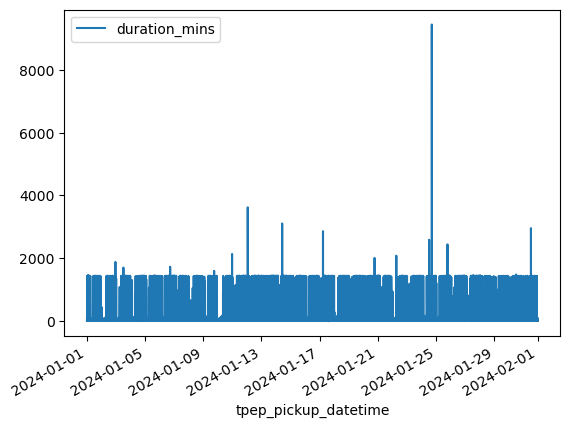

In [9]:
yellow_trips.plot(x='tpep_pickup_datetime', y='duration_mins')

In [10]:
# Removing outlier data by filtering data which pickup and dropoff date are the same
yellow_trips_filtered = yellow_trips[yellow_trips['tpep_pickup_datetime'].dt.date == yellow_trips['tpep_dropoff_datetime'].dt.date]
yellow_trips_filtered

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_borough,dropoff_borough,total_amount,duration_mins,day,time_period
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,Manhattan,Manhattan,22.70,19.80,Weekday,Midnight
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,Manhattan,Manhattan,18.75,6.60,Weekday,Midnight
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,Manhattan,Manhattan,31.30,17.92,Weekday,Midnight
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,Manhattan,Manhattan,17.00,8.30,Weekday,Midnight
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,Manhattan,Manhattan,16.10,6.10,Weekday,Midnight
...,...,...,...,...,...,...,...,...,...,...
2824457,2024-01-31 23:10:28,2024-01-31 23:18:30,1.0,3.51,Queens,Queens,30.31,8.03,Weekday,Evening
2824458,2024-01-31 23:01:04,2024-01-31 23:17:35,1.0,3.36,Manhattan,Manhattan,29.25,16.52,Weekday,Evening
2824459,2024-01-31 23:08:13,2024-01-31 23:25:00,3.0,3.30,Manhattan,Manhattan,23.70,16.78,Weekday,Evening
2824460,2024-01-31 23:49:46,2024-01-31 23:53:10,0.0,0.40,Manhattan,Manhattan,10.10,3.40,Weekday,Evening


<Axes: xlabel='tpep_pickup_datetime'>

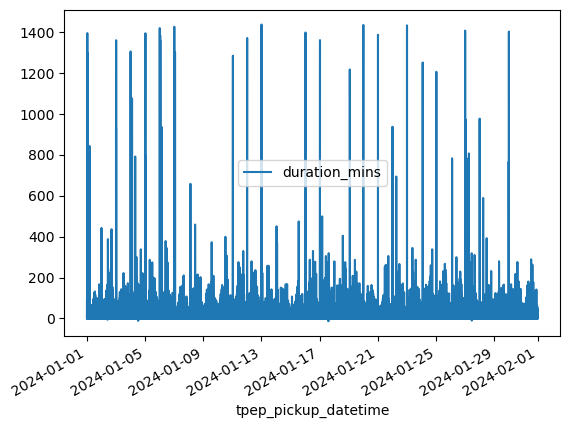

In [11]:
yellow_trips_filtered.plot(x='tpep_pickup_datetime', y='duration_mins')

In [12]:
yellow_trips.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,total_amount,duration_mins
count,2812441,2812441,2.812441e+06,2.812441e+06,2.812441e+06,2.812441e+06
mean,2024-01-17 01:26:13.307463,2024-01-17 01:41:44.294555,1.338760e+00,3.191946e+00,2.647242e+01,1.551645e+01
min,2024-01-01 00:00:00,2024-01-01 00:02:42,0.000000e+00,0.000000e+00,-8.010000e+02,-1.357000e+01
25%,2024-01-09 15:36:11,2024-01-09 15:52:48,1.000000e+00,1.000000e+00,1.525000e+01,7.070000e+00
50%,2024-01-17 10:41:32,2024-01-17 10:59:40,1.000000e+00,1.660000e+00,1.990000e+01,1.147000e+01
75%,2024-01-24 18:44:31,2024-01-24 18:59:33,1.000000e+00,3.060000e+00,2.820000e+01,1.848000e+01
max,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,1.540032e+04,5.000000e+03,9.455400e+03
std,NaN,NaN,8.498786e-01,1.205518e+01,2.220046e+01,3.557392e+01


In [13]:
# Making sure there is no negative value in the total_amount and duration (mins) column
yellow_trips_filtered = yellow_trips_filtered[(yellow_trips_filtered['total_amount'] > 0) & (yellow_trips_filtered['duration_mins'] > 0)]
yellow_trips_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2754481 entries, 0 to 2824461
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   pickup_borough         object        
 5   dropoff_borough        object        
 6   total_amount           float64       
 7   duration_mins          float64       
 8   day                    object        
 9   time_period            object        
dtypes: datetime64[us](2), float64(4), object(4)
memory usage: 231.2+ MB


In [14]:
# Take a sample of 10.000 trip records

sample_trips = yellow_trips_filtered.sample(n=10000, random_state=42)
sample_trips

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_borough,dropoff_borough,total_amount,duration_mins,day,time_period
178700,2024-01-03 14:54:23,2024-01-03 15:01:14,0.0,0.90,Manhattan,Manhattan,13.20,6.85,Weekday,Afternoon
469689,2024-01-06 15:54:52,2024-01-06 16:03:55,1.0,1.30,Manhattan,Manhattan,16.80,9.05,Weekend,Afternoon
747447,2024-01-10 02:03:11,2024-01-10 02:03:59,1.0,0.07,Manhattan,Manhattan,8.00,0.80,Weekday,Midnight
1757530,2024-01-20 18:20:45,2024-01-20 18:25:19,1.0,0.64,Manhattan,Manhattan,11.76,4.57,Weekend,Evening
164503,2024-01-03 11:17:18,2024-01-03 11:19:38,1.0,0.17,Manhattan,Manhattan,9.66,2.33,Weekday,Morning
...,...,...,...,...,...,...,...,...,...,...
491441,2024-01-06 18:23:01,2024-01-06 18:31:19,1.0,1.33,Manhattan,Manhattan,17.29,8.30,Weekend,Evening
2464918,2024-01-28 00:02:36,2024-01-28 00:02:50,1.0,0.00,Queens,Queens,7.25,0.23,Weekend,Midnight
1472900,2024-01-17 19:58:16,2024-01-17 20:14:40,3.0,1.79,Manhattan,Manhattan,26.52,16.40,Weekday,Evening
2038638,2024-01-23 21:24:29,2024-01-23 21:39:49,1.0,1.88,Manhattan,Manhattan,24.72,15.33,Weekday,Evening


## One-hot Encoding

In the latest dataset gained, four columns contain categorical data (pickup_borough, dropoff_borough, day, time_period). Therefore, to be able to do the regression, numerical values of each of these columns need to be extracted. Since we will use the sample_trips dataset with observations reduced to 10.000 for further analysis, one-hot encoding is a suitable method. One column from each categorical data column will be deleted to obey the K-1 dummy variables rule. 

In [15]:
sample_trips_numeric = pd.get_dummies(sample_trips)
sample_trips_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 178700 to 874052
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tpep_pickup_datetime           10000 non-null  datetime64[us]
 1   tpep_dropoff_datetime          10000 non-null  datetime64[us]
 2   passenger_count                10000 non-null  float64       
 3   trip_distance                  10000 non-null  float64       
 4   total_amount                   10000 non-null  float64       
 5   duration_mins                  10000 non-null  float64       
 6   pickup_borough_Bronx           10000 non-null  bool          
 7   pickup_borough_Brooklyn        10000 non-null  bool          
 8   pickup_borough_Manhattan       10000 non-null  bool          
 9   pickup_borough_Queens          10000 non-null  bool          
 10  pickup_borough_Unknown         10000 non-null  bool          
 11  dropoff_boroug

In [16]:
sample_trips_final = sample_trips_numeric.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_borough_Unknown', 'dropoff_borough_Unknown', 'day_Weekend', 'time_period_Morning'], axis=1)
sample_trips_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 178700 to 874052
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   passenger_count                10000 non-null  float64
 1   trip_distance                  10000 non-null  float64
 2   total_amount                   10000 non-null  float64
 3   duration_mins                  10000 non-null  float64
 4   pickup_borough_Bronx           10000 non-null  bool   
 5   pickup_borough_Brooklyn        10000 non-null  bool   
 6   pickup_borough_Manhattan       10000 non-null  bool   
 7   pickup_borough_Queens          10000 non-null  bool   
 8   dropoff_borough_Bronx          10000 non-null  bool   
 9   dropoff_borough_Brooklyn       10000 non-null  bool   
 10  dropoff_borough_EWR            10000 non-null  bool   
 11  dropoff_borough_Manhattan      10000 non-null  bool   
 12  dropoff_borough_Queens         10000 non-null

## Regression without Dimensionality Reduction

After obtaining a new dataframe with only numerical values, regression using random forest will be conducted. The regression will be done using RandomForestRegressor from the sklearn.ensemble library. To do the Random Forest regression, several processes needs to be carried out, from splitting train-test data, hyperparameters tuning, regression, calculating RMSE and R-square, to plotting feature importance.

1. Splitting Train and Test Data: This is the process where data is split into two groups, train data and test data, and train_test_split from sklearn.model_selection will be used. The proportion of train and test data will be 75% and 25% respectively. Aside from it is a common practice to do so, this proportion is used to ensure that there is sufficient unseen data to evaluate the model's performance while also still having plenty data to build the model without overfitting.

2. Hyperparameters Tuning: Just like any decision tree regression, regression Random Forest need two hyperparameters to work, which are maximum depth and minimum split. To get the best hyperparameters, cross validation will be conducted by using GridSearchCV from sklearn.model_selection.

3. Regression: Regression using Random Forest will be conducted by inputting the maximum depth and minimum split obtained from hyperparameters tuning, and train data obtained from splitting data process.

4. Calculating RMSE and R-square: After done with the regression process, RMSE and R-square will be calculated to get the accuracy score for the model. Both RMSE and R-square are obtained by applying the test data to the model built with the train data. RMSE values ranging from 0 to infinite where the lower values the better, while R-square values ranging from 0-1 ehere the higher the values the better.

5. Plotting Feature Importance: Feature importance provides the rank of variables based on their contribution to the final model. The rfpimp library will be used to conduct this process.

In [17]:
# Splitting the train-test data

random_state_split = 10
train_x, test_x, train_y, test_y = train_test_split(sample_trips_final.drop(['duration_mins'], axis=1), sample_trips_final['duration_mins'], random_state=random_state_split)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(7500, 17)
(7500,)
(2500, 17)
(2500,)
True
True


In [18]:
# Hyperparameters tuning

hyperparameters = {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 4, 6, 8, 10]}

random_state_dt = 1000
rf = RandomForestRegressor(random_state=random_state_dt)

clf = GridSearchCV(rf, hyperparameters)
clf.fit(train_x, train_y)

print(f"The best parameter value is: {clf.best_params_}")
print(f"The best score is: {clf.best_score_}")

The best parameter value is: {'max_depth': 40, 'min_samples_split': 6}
The best score is: 0.8144671738577612


In [19]:
# Random Forest Regression

rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=random_state_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=40, min_samples_split=6, random_state=1000)

In [20]:
# Calculating RMSE and R-square

print(f"R-square on the training data: {rf_final.score(X=train_x, y=train_y)}")
print(f"R-square on the testing data: {rf_final.score(X=test_x, y=test_y)}")

print(f"RMSE on the training data: {mean_squared_error(train_y, rf_final.predict(train_x), squared = False)}")
print(f"RMSE on the testing data: {mean_squared_error(test_y, rf_final.predict(test_x), squared=False)}")

R-square on the training data: 0.9476042375055281
R-square on the testing data: 0.837632034175681
RMSE on the training data: 2.6759747305207635
RMSE on the testing data: 5.012378921666809


                               Importance
Feature                                  
total_amount                     1.433280
trip_distance                    0.502803
time_period_Evening              0.018187
pickup_borough_Queens            0.014127
day_Weekday                      0.011425
time_period_Afternoon            0.006699
pickup_borough_Manhattan         0.005201
dropoff_borough_Queens           0.003999
time_period_Midnight             0.003841
pickup_borough_Brooklyn          0.003501
dropoff_borough_Manhattan        0.002017
dropoff_borough_EWR              0.001516
pickup_borough_Bronx             0.000873
dropoff_borough_Brooklyn         0.000593
passenger_count                  0.000525
dropoff_borough_Staten Island    0.000000
dropoff_borough_Bronx           -0.000089


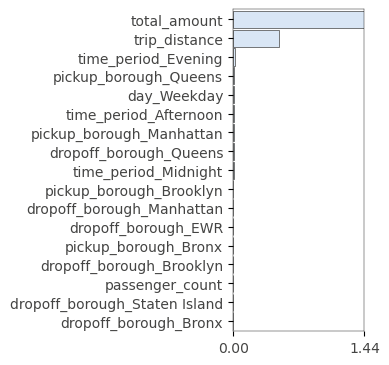

In [21]:
# Plotting Feature Importance

imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## Regression with Dimensionality Reduction

Dimensionality reduction is applied to reduce the number of dependent variables used in the regression. In this study, the PCA method was chosen since the dataset used in the analysis does not need any complicated reduction and this method does not require heavy computing as kernel PCA (kPCA) nor Locally Linear Embedding (LLE). The process of dimensionality reduction using PCA consists of standardisation of the independent variables, ranking Principle Components (PCs) and selecting number of components (k).

1. Standardisation: This process is crucial in doing PCA, as it is sensitive to the relative scales of different variables. StandardScaler from sklearn.preprocessing will be used in this process.

2. Ranking PCs: Using the PCA tool from sklearn.decomposition, several PCs will be shown and ranked based on its variance.

3. Selecting k: The most suitable number of components is obtained by using eigen value. This value is plotted to get the "knee" where it is considered as the best k value.

After the data with reduced dimension is obtained, random forest regression will be applied the same way as the previous one.

In [22]:
# Separating independent and dependent variables
X = sample_trips_final.drop('duration_mins', axis=1).values

list_var_X = sample_trips_final.columns.tolist()
list_var_X.remove('duration_mins')

Y = sample_trips_final.loc[:, ['duration_mins']].values

# Standardisation of the independent variable
X = StandardScaler().fit_transform(X)

# PCA
random_state_PCA = 20
pca = PCA(random_state = random_state_PCA)

X_new_components = pca.fit_transform(X)

# List of ranked PCs
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var_X)
df_PrincipleComp

,passenger_count,trip_distance,total_amount,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_Manhattan,pickup_borough_Queens,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_EWR,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island,day_Weekday,time_period_Afternoon,time_period_Evening,time_period_Midnight
0,0.022200,0.444837,0.434790,0.049795,0.081824,-0.425367,0.413898,0.080579,0.210680,0.089703,-0.357053,0.250376,0.035427,0.017141,0.003470,-0.011647,0.019086
1,0.015062,0.005137,0.016107,0.020358,0.003602,0.029867,-0.038344,-0.005167,-0.089174,0.087452,-0.008410,0.066231,-0.000452,-0.048174,0.698876,-0.696883,-0.014811
2,-0.081896,-0.182271,-0.216958,0.118748,0.378468,0.163473,-0.301759,0.102576,0.445728,-0.049429,-0.484202,0.244536,-0.028520,-0.154051,-0.081969,-0.092000,0.303748
3,-0.243697,-0.073108,-0.071646,0.194548,0.156816,0.001602,-0.074344,0.196865,0.176985,-0.036342,-0.125938,-0.038044,-0.085167,0.532893,0.191797,0.141852,-0.652165
4,-0.044692,0.087998,0.155437,0.047520,-0.385443,0.354622,-0.265645,0.116954,-0.204950,0.617185,-0.236819,0.293875,0.132656,0.092760,-0.076753,0.083243,-0.029707
5,-0.083945,-0.060571,-0.112635,0.478168,-0.281066,-0.074286,0.090493,0.445738,-0.362652,-0.439842,-0.022489,0.324739,-0.082278,-0.048965,-0.061128,-0.041565,0.104855
6,-0.112933,0.110388,0.104332,0.399414,0.120656,-0.036385,-0.046901,0.458480,0.118928,0.291886,0.185097,-0.596392,0.168230,-0.073844,-0.054385,-0.080801,0.209361
7,-0.585368,0.004298,-0.009078,-0.132689,0.011717,-0.018463,0.032118,-0.136714,-0.063021,-0.183751,0.018589,0.063066,0.735466,0.132604,-0.036705,-0.076172,0.108324
8,0.666826,-0.005015,-0.023677,0.100961,-0.013394,0.067113,-0.078355,0.106518,0.091832,-0.181285,-0.083011,-0.002647,0.612970,-0.116235,0.111234,0.113736,-0.244230
9,0.126352,-0.007765,0.003866,0.630420,-0.147187,-0.026412,-0.013866,-0.619328,0.146980,0.023523,0.052897,-0.002927,0.019942,0.331866,-0.073736,-0.092766,0.175702


In [23]:
# Explained variance ratio
print('Explained variance ratio of each component: ')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component: 
[0.22808306 0.09173138 0.08225398 0.07205492 0.06904043 0.06478923
 0.06352109 0.05924921 0.05796189 0.05393618 0.05189851 0.0504877
 0.02849907 0.01871112 0.0042772  0.00280647 0.00069857]


In [24]:
# Eigen values
print('Eigenvalues of each component: ')
print(pca.explained_variance_)

Eigenvalues of each component: 
[3.87779975 1.55958934 1.39845742 1.22505614 1.17380466 1.10152708
 1.07996649 1.00733734 0.98545064 0.91700673 0.88236292 0.8583767
 0.48453261 0.3181209  0.07271974 0.04771482 0.0118769 ]


<Axes: xlabel='PC'>

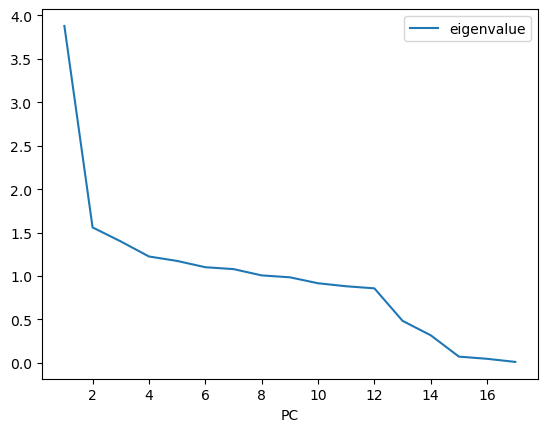

In [25]:
# Plotting the eigen value
df_eigen = pd.DataFrame({'eigenvalue': pca.explained_variance_,
                         'PC': list(range(1, pca.n_components_ + 1))})
df_eigen.plot.line(x = 'PC', y = 'eigenvalue')

In [26]:
# New dataframe with the chosen PCs
k = 2

pca_2 = PCA(n_components = k, whiten=True)

pca_final = pca_2.fit_transform(sample_trips_final)
pca_final = pd.DataFrame(pca_final, columns=[f'PC{i+1}' for i in range(k)])

pca_final

,PC1,PC2
0,-0.696150,-0.145513
1,-0.519915,-0.084859
2,-1.004210,-0.626241
3,-0.792599,-0.363381
4,-0.914260,-0.527389
...,...,...
9995,-0.515083,-0.221469
9996,-1.041891,-0.656693
9997,-0.022802,0.269472
9998,-0.108448,0.243601


In [27]:
# Splitting train and test data

X_two_pc = X_new_components[:, [0,1]]

split_rand_state = 10
train_x_pca, test_x_pca, train_y_pca, test_y_pca = train_test_split(X_two_pc, Y, random_state = split_rand_state)

# Random Forest Regression

rf_pca = RandomForestRegressor(max_depth=40, min_samples_split=6, random_state=split_rand_state)
rf_pca.fit(train_x_pca, train_y_pca)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=40, min_samples_split=6, random_state=10)

In [28]:
# Calculating RMSE and R-square
print(f"R-square on the training data: {rf_pca.score(X=train_x_pca, y=train_y_pca)}")
print(f"R-square on the testing data: {rf_pca.score(X=test_x_pca, y=test_y_pca)}")

print(f"RMSE on the training data: {mean_squared_error(train_y_pca, rf_pca.predict(train_x_pca), squared = False)}")
print(f"RMSE on the testing data: {mean_squared_error(test_y_pca, rf_pca.predict(test_x_pca), squared=False)}")

R-square on the training data: 0.924411932263987
R-square on the testing data: 0.7309531774494937
RMSE on the training data: 3.214108604054381
RMSE on the testing data: 6.452197518376997


# Discussion

## Regression without Dimensionality Reduction

In the first analysis, regression without dimensionality reduction has been conducted. After doing one-hot encoding and dropping one column for each categorical data column, 18 dependent variables were obtained and all these variables were used in the Random Forest regression. After hyperparameters tuning, it was found that the best maximum depth and minimum splits for the data were 40 and 6 respectively. In the end, the RMSE for train and test data were 2.676 and 5.012 resepectively, while the R-square for train and test data were 0.948 and 0.837 respectively. These values demonstrate that the model is well-built and capable to predict using the unseen data. The advantage of this analysis is the capability to understand which dependent variable influences the model the most, in this case it was total_amount.

## Regression with Dimensionality Reduction

In the second analysis, regression with dimensionality reduction has been conducted. The original 18 variables have been reduced into only two PCs. Two PCs were selected based on the plotting of eigen value, where there was a sharp bend around the value 2. After doing Random Forest regression, the RMSE for train and test data were 3.214 and 6.452 respectively, while the R-square for train and test data were 0.924 and 0.731. These values also demonstrate that the model is well built and capable to predict using the unseen data. However, in this analysis, the significance of each dependent variable could not be recognized since the variables have been combined.

# Conclusion

This study was conducted to understand how dimensionality reduction using PCA method affect Random Forest regression to predict Yellow Taxi trip duration. While both methods, with and without PCA, resulted in high-accuracy models, the difference was insignificant. The PCA method might bring more significant impact in bigger dataset with more than 20 variables.

# Reference

- Bohannon, M. (2024) ‘NYC’s Subway Violence: Here’s What Caused A New National Guard Crackdown’, 6 March. Available at: https://www.forbes.com/sites/mollybohannon/2024/03/06/nycs-subway-violence-heres-what-caused-a-new-national-guard-crackdown/

- Gupta, B. et al. (2018) ‘Taxi Travel Time Prediction Using Ensemble-Based Random Forest and Gradient Boosting Model’, in E.B. Rajsingh et al. (eds) Advances in Big Data and Cloud Computing. Singapore: Springer Singapore (Advances in Intelligent Systems and Computing), pp. 63–78. Available at: https://doi.org/10.1007/978-981-10-7200-0_6

- Hu, W. (2017) ‘Yellow Cab, Long a Fixture of City Life, Is for Many a Thing of the Past’, 15 January. Available at: https://www.nytimes.com/2017/01/15/nyregion/yellow-cab-long-a-fixture-of-city-life-is-for-many-a-thing-of-the-past.html#:~:text=Yellow%20became%20the%20official%20color,congestion%20and%20cut%2Drate%20fares

- Kankanamge, K.D. et al. (2019) ‘Taxi Trip Travel Time Prediction with Isolated XGBoost Regression’, in 2019 Moratuwa Engineering Research Conference (MERCon). 2019 Moratuwa Engineering Research Conference (MERCon), Moratuwa, Sri Lanka: IEEE, pp. 54–59. Available at: https://doi.org/10.1109/MERCon.2019.8818915.

- Ley, A. (2022) ‘Yellow cabs are struggling, congestion pricing could deal a new blow’, 11 October. Available at: https://www.nytimes.com/2022/10/11/nyregion/nyc-traffic-yellow-cab-tolls.html

- Mays, L., Baldwin, S. and Pettitt, J. (2023) ‘New York City taxis fight for survival against Uber and Lyft’, 15 July. Available at: https://www.cnbc.com/2023/07/15/new-york-city-taxis-fight-for-survival-against-uber-and-lyft.html.

- Poongodi, M. et al. (2022) ‘New York City taxi trip duration prediction using MLP and XGBoost’, International Journal of System Assurance Engineering and Management, 13(S1), pp. 16–27. Available at: https://doi.org/10.1007/s13198-021-01130-x

- Reddy Maddikunta, P.K. et al. (2020) ‘Predictive model for battery life in IoT networks’, IET Intelligent Transport Systems, 14(11), pp. 1388–1395. Available at: https://doi.org/10.1049/iet-its.2020.0009

- Zhu, C., Idemudia, C.U. and Feng, W. (2019) ‘Improved logistic regression model for diabetes prediction by integrating PCA and K-means techniques’, Informatics in Medicine Unlocked, 17, p. 100179. Available at: https://doi.org/10.1016/j.imu.2019.100179
